In [1]:
from gym import Env
from gym.spaces import Box

import matplotlib
from matplotlib import pyplot as plt

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
import random
import const as c

import numpy as np
import os

from typing import List, Optional, TypedDict

In [2]:
class spaceEnv(Env):
    """
    Observation space is a box of shape (5, 4).
    Columns represent:
    0: Polar postiion r
    1: Polar position theta,
    2: Distance to target position
    3: Distance to the object currently being moved. For the current object this is set to negative.
    Rows represent objects. Current object in 0, and the rest in order of closeness.

    Action space is a boc of shape (2, ) with values between -1 and 1 for first entry and 0 and 1 for second entry   
    """
    metadata = {"render_modes": ["human"], "render_fps": 2}
    
    def __init__(self, render_mode: Optional[str]=None, full_mode: bool = True) -> None:
        # Load planet data from files
        with open('../src/data/data1.npy', 'rb') as file:
            self.position_data_polar = np.load(file)   # Numpy array of body positions in polar coordinates. r,v (5206896, 10, 2)
            self.position_data_XY = np.load(file)      # Numpy array of body positions in cortesian coordinates. x,y (5206896, 10, 2)
            self.time_data = np.load(file)            # Numpy array of time stamp. year, month, day, hour, minute (5206896, 5)
        with open('../src/data/data2.npy', 'rb') as file:
            self.start_positions = np.load(file)      # Numpy array of allowed start positions = no initial collision (12511,)
            self.min_dist_squared = np.load(file)      # Numpy array of 'minimum distance squared' between planets (10, 10)
        
        self.full_mode = full_mode
        
        self.objects: List[str] = self.get_object_list()
        self.current_step = self.get_starting_step(full_mode)   
        self.object_positions: dict[str, dict[str, np.float32]] = self.get_starting_positions()

        self.object_count: int = 0
    
        # Define action space
        self.action_space = Box(
            low=np.array([-1.0, 0.0]),
            high=np.array([1.0, 1.0]), 
        )
        self.render_mode = render_mode

        # Define observation space 
        self.observation_space = Box(low=-2830.0, high=2830.0, shape=(5, 4), dtype=np.float32)      
        
    def get_object_list(self) -> List[str]:
        objects = c.objects.copy()
        return objects

    def get_starting_step(self, mode: bool) -> int:
        if mode:
            position = int(np.random.choice(self.start_positions))
        else:
            position = 0
        return position  
    
    def get_starting_positions(self) -> dict[str, dict[str, np.float32]]:
        return {
            "sun":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][0][0],
                "position_polar_theta": self.position_data_polar[self.current_step][0][1],
                "target_position_dist": self.position_data_polar[self.current_step][0][0],
                "target_position_theta": self.position_data_polar[self.current_step][0][1],
                "distance_to_target": 0   
            },
            "jupiter":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][1][0],
                "position_polar_theta": self.position_data_polar[self.current_step][1][1],
                "target_position_dist": self.position_data_polar[self.current_step][1][0],
                "target_position_theta": self.position_data_polar[self.current_step][1][1],   
                "distance_to_target": 0  
            },
            "neptune":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][2][0],
                "position_polar_theta": self.position_data_polar[self.current_step][2][1],
                "target_position_dist": self.position_data_polar[self.current_step][2][0],
                "target_position_theta": self.position_data_polar[self.current_step][2][1],   
                "distance_to_target": 0  
            },
            "saturn":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][3][0],
                "position_polar_theta": self.position_data_polar[self.current_step][3][1],
                "target_position_dist": self.position_data_polar[self.current_step][3][0],
                "target_position_theta": self.position_data_polar[self.current_step][3][1],   
                "distance_to_target": 0  
            },
            "uranus":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][4][0],
                "position_polar_theta": self.position_data_polar[self.current_step][4][1],
                "target_position_dist": self.position_data_polar[self.current_step][4][0],
                "target_position_theta": self.position_data_polar[self.current_step][4][1],   
                "distance_to_target": 0  
            },
            "moon":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][5][0],
                "position_polar_theta": self.position_data_polar[self.current_step][5][1],
                "target_position_dist": self.position_data_polar[self.current_step][5][0],
                "target_position_theta": self.position_data_polar[self.current_step][5][1],   
                "distance_to_target": 0  
            },
            "mercury":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][6][0],
                "position_polar_theta": self.position_data_polar[self.current_step][6][1],
                "target_position_dist": self.position_data_polar[self.current_step][6][0],
                "target_position_theta": self.position_data_polar[self.current_step][6][1],   
                "distance_to_target": 0  
            },
           "venus":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][7][0],
                "position_polar_theta": self.position_data_polar[self.current_step][7][1],
                "target_position_dist": self.position_data_polar[self.current_step][7][0],
                "target_position_theta": self.position_data_polar[self.current_step][7][1],   
                "distance_to_target": 0  
            },
            "mars":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][8][0],
                "position_polar_theta": self.position_data_polar[self.current_step][8][1],
                "target_position_dist": self.position_data_polar[self.current_step][8][0],
                "target_position_theta": self.position_data_polar[self.current_step][8][1],   
                "distance_to_target": 0  
            },
            "stellanova":{ 
                "position_polar_dist": self.position_data_polar[self.current_step][9][0],
                "position_polar_theta": self.position_data_polar[self.current_step][9][1],
                "target_position_dist": self.position_data_polar[self.current_step][9][0],
                "target_position_theta": self.position_data_polar[self.current_step][9][1],   
                "distance_to_target": 0  
            }
        }

    def reset(self):
        # Reset step counter
        self.current_step = self.get_starting_step(self.full_mode)
        self.objects = self.get_object_list()
        self.object_positions = self.get_starting_positions()
        self.object_count = 0

        obs = np.array(self.reset_obs())
        print(self.observation_space.sample())
        print(self.observation_space.sample().shape)
        print(type(self.observation_space.sample()))
        print(obs)
        print(type(obs))
        print(obs.shape)
        return obs
          
    
    def choose_current_object(self) -> str:
        """For now this is a dummy method, that just returns a popped object from the object list"""
        obj = self.objects.pop()
        self.object_count+=1
        return obj
    
    def calculate_nearest_four(self, current_object: str) -> List[str]:
        """For now this is a dummy method, that returns four random planets from the object list"""
        print(current_object)
        objects = self.objects.copy()
        print(objects)
        objects2 = objects.remove(current_object)
        print(objects2)
        return random.sample(objects2, 4)

    def step(self, action: np.ndarray):

        current_object = self.choose_current_object()
        nearest_four = self.calculate_nearest_four(current_object=current_object)

        target_position_dist = self.object_positions[current_object]["target_position_dist"]
        target_position_theta = self.object_positions[current_object]["target_position_theta"]

        new_position = self.calc_new_position(action=action, current_object=current_object)

        current_postion = [
            self.object_positions[current_object]["position_polar_dist"],
            self.object_positions[current_object]["position_polar_theta"]
        ]

        distance_to_target = self.cartesian_distance(
                            current_position_dist=current_postion[0],
                            current_position_theta=current_postion[1],
                            new_position_dist=target_position_dist,
                            new_position_theta=target_position_theta
                        )
        
        reward = self.calc_reward(distance_to_target=distance_to_target)
        
        obs = self.observation(
            new_position=new_position,
            distance_to_target=distance_to_target,
            nearest_objects=nearest_four
        )

        done = (True if self.current_step==self.position_data_polar.shape[0] else False)        

        info = {}

        if self.object_count==9:
            self.update_current_step


        return self.state, reward, done, info

    def update_current_step(self):
        self.current_step+=1
        self.object_count = 0
        self.objects = self.get_object_list()
    
    def update_position(self,
                        current_object: str,
                        new_position: List[float],
                        distance_to_target: float):
        self.object_positions[current_object]["position_polar_dist"] = new_position[0]
        self.object_positions[current_object]["position_polar_dist"] = new_position[1]
        self.object_positions[current_object]["distance_to_target"] = distance_to_target

    def update_targets(self):
        for entry in enumerate(self.object_positions.keys()):
            self.object[entry][1]["target_position_dist"] = self.position_data_polar[self.current_step][entry[0]][0]
            self.object[entry][1]["target_position_theta"] = self.position_data_polar[self.current_step][entry[0]][1]

    def calc_new_position(self, action: np.ndarray, current_object: str) -> List[float]:
        new_dist = self.object_positions[current_object]["position_polar_dist"] + action[0]*c.BOARD_RADIUS
        new_theta = self.object_positions[current_object]["position_polar_theta"] + action[1]*2*np.pi
        return [new_dist, new_theta]
    
    
    def cartesian_distance(self,
                         current_position_dist: float,
                         current_position_theta: float, 
                         new_position_dist: float,
                         new_position_theta: float
                         ) -> float:
        
        current_cartesian = self.polar_to_cartesian(
                                dist=current_position_dist,
                                theta=current_position_theta
                            )
        new_cartesian = self.polar_to_cartesian(
                                dist=new_position_dist,
                                theta=new_position_theta
                            )

        distance = abs(np.linalg.norm(current_cartesian - new_cartesian))

        return distance
    
    @staticmethod
    def calc_reward(distance_to_target) -> float:
        if distance_to_target < 0.5:
            reward = 10
        else:
            reward = -(distance_to_target**2)

        return reward
    
    @staticmethod
    def polar_to_cartesian(dist: float, theta: float) -> np.ndarray:
        x = dist*np.cos(theta)
        y = dist*np.sin(theta)

        return np.array([x, y])


    def calc_planet_order(self, polarPositions):
        return iter(np.argsort(polarPositions[:,3]))

    def observation(self, 
                    new_position: List[float],  
                    distance_to_target: float,
                    nearest_objects:List[str]
                    ) -> np.ndarray:
        obs = np.zeros((5, 4))
        obs[0, 0] = new_position[0]
        obs[0, 1] = new_position[1]
        obs[0, 1] = distance_to_target
        obs[0, 4] = -99.0

        for object in enumerate(nearest_objects):
            row = object[0] + 1
            dist = self.object_positions[object[1]]["position_polar_dist"]
            theta = self.object_positions[object[1]]["position_polar_theta"]

            obs[row, 0] = dist
            obs[row, 1] = theta
            obs[row, 2] = self.object_positions[object[1]]["distance_to_target"]

            current_cartesian = self.polar_to_cartesian(new_position[0], new_position[1])
            object_cartesian = self.polar_to_cartesian(dist, theta)
            distance_to_current = self.cartesian_distance(
                                        current_position_dist=dist,
                                        current_position_theta=theta,
                                        new_position_dist=new_position[0],
                                        new_position_theta=new_position[1]
                                    )
            obs[row, 3] = distance_to_current

            return np.array(obs)

    def reset_obs(self) -> np.ndarray:
        obs = np.zeros((5, 4))
        
        for obj in enumerate(self.objects[0:5]):
            obs[obj[0], 0] = np.float32(self.object_positions[obj[1]]["position_polar_dist"])
            obs[obj[0], 1] = np.float32(self.object_positions[obj[1]]["position_polar_theta"])
            obs[obj[0], 2] = np.float32(0.0)
            obs[obj[0], 3] = np.float32(-99.0)

        return np.array(obs)




# myEnv = spaceEnv()
# check_env(myEnv)
# print('done')

In [3]:
myEnv = spaceEnv()

/home/marcla/astro2/.venv/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


numpy.ndarray

In [4]:
myEnv.step(myEnv.action_space.sample())

stellanova
['sun', 'jupiter', 'neptune', 'saturn', 'uranus', 'moon', 'mercury', 'venus', 'mars']


ValueError: list.remove(x): x not in list

In [243]:
check_env(myEnv)

[[ 2161.7087   -466.1456   2542.6006    990.28284]
 [ 1063.1665    210.65302 -2519.928     691.28516]
 [ 2796.9963  -2576.4753    429.14902   401.30392]
 [  520.6811  -2156.6013   2172.269    1890.3079 ]
 [  233.84991  1049.8556   1972.8816   2826.4106 ]]
(5, 4)
<class 'numpy.ndarray'>
[[ 9.25275452e+02  4.22962666e+00  0.00000000e+00 -9.90000000e+01]
 [ 1.34000000e+03  1.27945805e+00  0.00000000e+00 -9.90000000e+01]
 [ 7.47888123e+02  3.96299624e+00  0.00000000e+00 -9.90000000e+01]
 [ 1.34000000e+03  1.11787021e+00  0.00000000e+00 -9.90000000e+01]
 [ 7.36369690e+02  1.90346336e+00  0.00000000e+00 -9.90000000e+01]]
<class 'numpy.ndarray'>
(5, 4)


/home/marcla/astro2/.venv/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:130: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/home/marcla/astro2/.venv/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


AssertionError: The observation returned by the `reset()` method does not match the given observation space

In [115]:
ele = {"abe": "ko", "johnny": "navn", "albert": "pers"}

print(ele[0:2])

TypeError: unhashable type: 'slice'

In [117]:
objects = ["ebbe", "kaj", "jin", "palle"]

print(objects[0:3])

['ebbe', 'kaj', 'jin']


In [10]:
utils.flatten_space(test_space)

Box([-1500. -1500.     0.     0. -2830.], [1500.        1500.        1500.           6.2831855 2830.       ], (5,), float32)

In [94]:
sct = Box(
            low=np.array([-1.0, 0.0, 0.0]),
            high=np.array([1.0, 1.0, 8.0]), 
            dtype=np.float32
        )

sct.sample()

array([-0.67751193,  0.52740717,  1.268986  ], dtype=float32)

In [10]:
utils.flatten_space(test_space)

NotImplementedError: Unknown space: `Dict('X_position_self': Box(-1500.0, 1500.0, (1,), float32), 'Y_position_self': Box(-1500.0, 1500.0, (1,), float32), 'distance_to_target_position': Box(0.0, 1500.0, (1,), float32), 'polar_angle_self': Box(0.0, 6.2831855, (1,), float32), 'polar_distance_self': Box(-2830.0, 2830.0, (1,), float32))`

In [54]:
myEnv = spaceEnv()

/home/marcla/astro2/.venv/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [102]:
planetlist = ["sun", "jupiter", "neptune", "saturn", "uranus", "moon", "mercury", "venus", "mars", "stellanova"]

In [6]:
space = Dict({"position": Discrete(2), "velocity": Box(0, 1, shape=(2, 2))}) 
utils.flatten_space(space.sample())

NotImplementedError: Unknown space: `OrderedDict([('position', 0), ('velocity', array([[0.7338004 , 0.48042446],
       [0.94172806, 0.5077621 ]], dtype=float32))])`

In [2]:
spacy = Dict({"position": Box(-1, 1, shape=(2,)), "color": Discrete(3)}, seed=42)

NameError: name 'Discrete' is not defined

In [31]:
maximum_x = 0
minimum_x = 0
maximum_y = 0
minimum_y = 0
for i in range(myEnv.position_data_XY.shape[0]):
    xmax = max(myEnv.position_data_XY[i][:, 0])
    xmin = min(myEnv.position_data_XY[i][:, 0])
    ymax = max(myEnv.position_data_XY[i][:, 1])
    ymin = min(myEnv.position_data_XY[i][:, 1])
    if xmax > maximum_x:
        maximum_x = xmax
    if xmin < minimum_x:
        minimum_x = xmin
    if ymax > maximum_y:
        maximum_y = ymax
    if ymin < minimum_y:
        minimum_y = ymin

In [35]:
minimum_y

-1197.3098

In [4]:
from __future__ import annotations
from typing import List, Dict
import math
import numpy as np
 
class Planet:
    def __init__(self, name: str, starting_position: np.ndarray, trajectory: List):
        self.name: str = name
        self.trajectory: List = trajectory
        self.planets: List[Planet] = []
        self.starting_position: np.ndarray = starting_position
        self.position: np.ndarray = starting_position
        self.ideal_postion: np.ndarray = None
        self.next_position: np.ndarray = None
        self.distance_to_other_planets: List[np.ndarray] = []
        self.current_step = 0
        self.deviation: np.float32 = 0
        self.distance_to_ideal_position: np.float32 = 0
        self.distance_to_nearest_planet: np.float32 = 0
    
    def set_other_planets(self, other_planets: List) -> List[Planet]:
        self.planets = other_planets
        
    def get_ideal_position(self):
        ideal_position = self.trajectory[self.current_step]
        self.ideal_postion = ideal_position

    def get_direction(self):
        raise NotImplementedError

    def get_distance_to_other_planets(self) -> Dict[str, np.float32]:
        dist_dict = {}
        for planet in self.planets:
            if planet.name != self.name:
                distance = math.dist(self.position, planet.position)
                dist_dict[planet.name] = distance
        return dist_dict

    def get_next_position(self, action: int) -> np.ndarray:
        deviation = self.get_deviation(action)
        if self.deviation < 10:
            self.deviation += deviation

        if self.current_step < len(self.trajectory) - 1:
            next_y: np.float32 = self.trajectory[self.current_step+1][1] + self.deviation
            next_position = np.array([self.current_step+1, next_y], dtype=np.float32)
        else:
            next_position = self.starting_position
        return next_position

    def update_current_step(self):
        self.current_step = self.current_step + 1
    
    def get_deviation(self, action: int) -> np.float32:
        if action==1:
            deviation = -0.1
        elif action==2:
            deviation = 0.1
        else:
            deviation = 0
        return deviation

    def get_distance_to_ideal_position(self) -> np.float32:
        self.get_ideal_position()
        distance: np.float32 = math.dist(self.position, self.ideal_postion)
        return distance

    def update_position(self, action: int):
        self.position = self.get_next_position(action)
    


### Creating trajectories

In [6]:
def get_point(x: float, a: float, b: float) -> np.array:

    root_number = (1-(x**2/a**2))*b**2
    if root_number < 0:
        root_number*-1
        y = np.sqrt(root_number)
        return np.array([x, -y])
    else:
        y = np.sqrt(root_number)
        return np.array([x, y]) 

In [11]:
a_1 = 32
b_1 = 4.8
trajectory_1 = []
for i in range(-32,33):
    trajectory_1.append(np.round(get_point(x=i, a=a_1, b=b_1), 2))

trajectory_earth = trajectory_1.copy()
for el in trajectory_1:
    if el[0]==32 or el[0]==-32:
        continue
    else:
        trajectory_earth.append(np.array([-el[0], -el[1]]))

a_2 = 16
b_2 = 8.9
trajectory_2 = []
for i in range(-16,17
               ):
    trajectory_2.append(np.round(get_point(x=i, a=a_2, b=b_2), 2))

trajectory_venus = trajectory_2.copy()
for el in trajectory_2:
    if el[0]==16 or el[0]==-16:
        continue
    else:
        trajectory_venus.append(np.array([-el[0], -el[1]]))

#setteing starting point to zero
new_earth_1 = trajectory_earth[32:]
new_earth_2 = trajectory_earth[0:32]
final_trajectory_earth = new_earth_1 + new_earth_2

new_venus_1 = trajectory_venus[16:]
new_venus_2 = trajectory_venus[0:16]
final_trajectory_venus = new_venus_1 + new_venus_2 + new_venus_1 + new_venus_2


### Adding the planets

In [12]:
earth = Planet(name="earth", starting_position=np.array([0, 4.8]), trajectory=final_trajectory_earth)
venus = Planet(name="venus", starting_position=np.array([0, 8.9]), trajectory=final_trajectory_venus)

In [20]:
venus.get_distance_to_other_planets()

{'earth': 4.1000000000000005}

In [24]:
earth.trajectory

[array([-32.,   0.]),
 array([-31.  ,   1.19]),
 array([-30.  ,   1.67]),
 array([-29.  ,   2.03]),
 array([-28.  ,   2.32]),
 array([-27.  ,   2.58]),
 array([-26. ,   2.8]),
 array([-25.,   3.]),
 array([-24.  ,   3.17]),
 array([-23.  ,   3.34]),
 array([-22.  ,   3.49]),
 array([-21.  ,   3.62]),
 array([-20.  ,   3.75]),
 array([-19.  ,   3.86]),
 array([-18.  ,   3.97]),
 array([-17.  ,   4.07]),
 array([-16.  ,   4.16]),
 array([-15.  ,   4.24]),
 array([-14.  ,   4.32]),
 array([-13.  ,   4.39]),
 array([-12.  ,   4.45]),
 array([-11.  ,   4.51]),
 array([-10.  ,   4.56]),
 array([-9.  ,  4.61]),
 array([-8.  ,  4.65]),
 array([-7.  ,  4.68]),
 array([-6.  ,  4.71]),
 array([-5.  ,  4.74]),
 array([-4.  ,  4.76]),
 array([-3.  ,  4.78]),
 array([-2.  ,  4.79]),
 array([-1. ,  4.8]),
 array([0. , 4.8]),
 array([1. , 4.8]),
 array([2.  , 4.79]),
 array([3.  , 4.78]),
 array([4.  , 4.76]),
 array([5.  , 4.74]),
 array([6.  , 4.71]),
 array([7.  , 4.68]),
 array([8.  , 4.65]),
 arr

AttributeError: 'list' object has no attribute 'set_xdata'

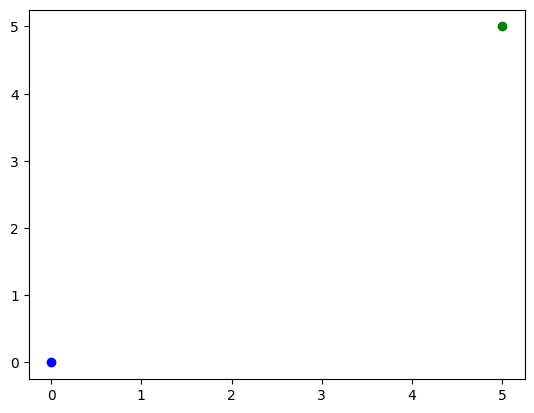

: 

In [51]:
import time
from IPython import display

fig = plt.figure()
plt.ion()
ax = fig.add_subplot(111)
earth = ax.plot(0, 0, 'bo')
venus = ax.plot(5, 5, 'go')
for i in range(5):
    earth.set_xdata(i, i)
    earth.set_ydata(4, 5-i)

    venus.set_xdata(5-i, 5-i)

    fig.canvas.draw()
    
    fig.canvas.flush_events()
    time.sleep(0.1)

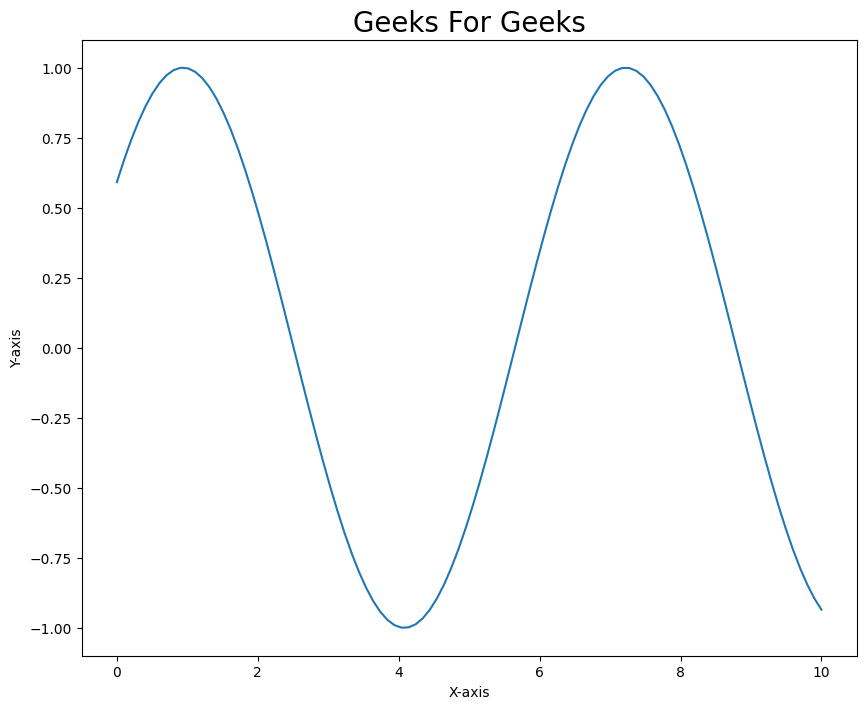

In [50]:
# importing libraries
import numpy as np
import time
import matplotlib.pyplot as plt
 
# creating initial data values
# of x and y
x = np.linspace(0, 10, 100)
y = np.sin(x)
 
# to run GUI event loop
plt.ion()
 
# here we are creating sub plots
figure, ax = plt.subplots(figsize=(10, 8))
line1, = ax.plot(x, y)
 
# setting title
plt.title("Geeks For Geeks", fontsize=20)
 
# setting x-axis label and y-axis label
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
 
# Loop
for _ in range(50):
    # creating new Y values
    new_y = np.sin(x-0.5*_)
 
    # updating data values
    line1.set_xdata(x)
    line1.set_ydata(new_y)
 
    # drawing updated values
    figure.canvas.draw()
 
    # This will run the GUI event
    # loop until all UI events
    # currently waiting have been processed
    figure.canvas.flush_events()
 
    time.sleep(0.1)

### Setting up test env

The observation space is a box of of dimension (2, 4) - two rows and four columns.<br>
The rows represent planets, and the columns represent:<br>

0. planet position, x-coordinate
1. planet position, y-coordinate
2. distance to nearest planet
3. distance to ideal position

The state of the environment is a (2, 4) np.array matching the observation space described above

In [27]:
class StarViz:
    def __init__(self, planets: List[Planet]) -> None:
        max_and_min = self.get_max_and_min()
        self.figure = self.get_fig()

    def get_fig(self):
        fig = plt.figure()
        plt.xlim(self.max_and_min["min_x"], self.get_max_and_min["max_x"])
        plt.ylim(self.max_and_min["min_y"], self.get_max_and_min["max_y"])
    
    def get_max_and_min(self) -> Dict[str, int]:
        positions = self.concat_positions()
        min_x = 0
        max_x = 0
        min_y = 0
        max_y = 0
        for position in positions:
            if position[0] < min_x:
                min_x = position[0]
            elif position[0] > max_x:
                max_x = position[0]
            
            if position[1] < min_y:
                min_y = position[1]
            elif position[1] > max_y:
                max_y = position[1]
        
        return {
            "min_x": min_x,
            "max_x": max_x,
            "min_y": min_y,
            "max_y": max_y
        }

    def concat_positions(self) -> List: 
        positions = []
        for planet in self.planets:
            positions = positions + planet.trajectory
        return positions
    
    def plot(self):
        

In [14]:
class spaceEnv(Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 2}
    
    def __init__(self, planets: List[Planet], render_mode: str) -> None:
        self.action_space = MultiDiscrete([3, 3])
        self.observation_space = Box(low=-100.0, high=100.0, shape=(2, 4), dtype=np.float32)
        self.render_mode = render_mode
        #set starting state
        self.state: np.ndarray = np.array(
                        [
                    [0.0, 4.8, 4.1, 0.0],
                    [0.0, 8.9 , 4.1, 0.0]          
                ], dtype=np.float32
            )
        self.planets = planets
        self.size: int = self.calculate_size()
        self.current_step = 0
        self.visualizer = StarViz(planets=self.planets)
        self.clock = None
    
    def calculate_size(self) -> int:
        x_positions = []
        y_positions = []
        for planet in self.planets:
            for position in planet.trajectory:
                x_positions.append(np.abs(position[0]))
                y_positions.append(np.abs(position[1]))

        return round(max([max(x_positions), max(y_positions)])) + 200
    
    def step(self, action: np.ndarray):
        self.state = self.calculate_state(action)
        obs: np.ndarray = self.state
        if self.render_mode=="human":
            self._render_frame()
        reward = self.calculate_reward()
        self.current_step+=1
        self.update_planet_steps()
        done = self.is_done()
        info = {
            "venus": {
                "name": self.planets[0].name,
                "position": self.planets[0].position,
                "distance_to_nearest": self.planets[0].distance_to_nearest_planet,
                "deviation": self.planets[0].deviation,
                "current_step": self.planets[0].current_step
            },
    
            "earth": {
                "name": self.planets[1].name,
                "position": self.planets[1].position,
                "distance_to_nearest": self.planets[1].distance_to_nearest_planet,
                "deviation": self.planets[1].deviation,
                "current_step": self.planets[1].current_step
            }, 
            "step no": self.current_step
        }

        return obs, reward, done, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
       

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # Now we draw the planets
        for planet in self.planets:
            pygame.draw.circle(
                canvas,
                (0, 0, 255),
                (planet.position + 0.5) * pix_square_size,
                pix_square_size / 3,
            )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
    
    def reset(self):
        self.state: np.ndarray = np.array(
                        [
                    [0.0, 4.8, 4.1, 0.0],
                    [0.0, 8.9 , 4.1, 0.0]            
                ],
                dtype=np.float32
            )
        self.current_step = 0
        for planet in self.planets:
            planet.position = planet.starting_position
            planet.deviation = 0.0
            planet.current_step = 0
        return self.state

    def calculate_reward(self):
        reward = 0
        for planet in self.planets:
            if np.abs(planet.distance_to_nearest_planet) > 5:
                reward+=0
                #print("distance_greater than five")
            else:
                reward-=planet.distance_to_nearest_planet
                #print("distance less than five")
                #print(f"distanceto_idealposition for {planet} is {planet.distance_to_ideal_position}")
            if np.abs(planet.distance_to_ideal_position) > 0:
                reward-=np.abs(planet.distance_to_ideal_position)
                #print("distance to ideal less than five")
            else:
                reward+=1
            if np.abs(planet.distance_to_nearest_planet) < 0.1:
                print("collision")
                reward-=100
                
        return reward

    def calculate_state(self, action: np.ndarray) -> np.ndarray:
        positions = []
        for action_number, planet in enumerate(self.planets):
            planet.update_position(action[action_number])
            positions.append(planet.position)
            planet.update_current_step()

        distances = []
        for planet in self.planets:
            distance_to_nearest_planet: np.float32 = min(planet.get_distance_to_other_planets().values())      
            planet.distance_to_nearest_planet = distance_to_nearest_planet
            distance_to_ideal_position = planet.get_distance_to_ideal_position()
            distances.append([
                distance_to_nearest_planet,
                distance_to_ideal_position
            ])
        
        state_list = []
        for i in range(len(self.planets)):
            row = [positions[i][0], positions[i][1], distances[i][0], distances[i][1]]
            state_list.append(row)
        
        return np.array(state_list, dtype=np.float32)
    
    def update_planet_steps(self):
        for planet in self.planets:
            if planet.current_step < len(planet.trajectory) - 1:
                planet.current_step = self.current_step
    
    def is_done(self):
        if self.current_step==127:
            done = True
        else:
            done = False
        return done
        
    

### Test env

In [18]:

earth = Planet(name="earth", starting_position=np.array([0, 4.8]), trajectory=trajectory_earth)
venus = Planet(name="venus", starting_position=np.array([0, 8.9]), trajectory=trajectory_venus)

In [19]:
planets = [earth, venus]

earth.set_other_planets(planets)
venus.set_other_planets(planets)

env = spaceEnv(planets=planets, render_mode="human")
env.reset()

array([[0. , 4.8, 4.1, 0. ],
       [0. , 8.9, 4.1, 0. ]], dtype=float32)

In [11]:
check_env(env, warn=True)

c:\Users\Marti\astroClock\astro\lib\site-packages\stable_baselines3\common\env_checker.py:190: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
C:\Users\Marti\AppData\Local\Temp\ipykernel_13756\2306706097.py:91: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pygame.draw.circle(


numpy.ndarray

In [16]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        # action = env.action_space.sample()
        action = [0, 0]
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{} info{}'.format(episode, score, info))
env.close()

C:\Users\Marti\AppData\Local\Temp\ipykernel_9180\2306706097.py:91: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pygame.draw.circle(


IndexError: list index out of range

In [64]:
env.close()

: 

In [340]:
venus.trajectory[8]

array([8.  , 7.71])

In [371]:
venus.trajectory[14]

array([14.  ,  4.31])

In [47]:
env.reset()

array([[0. , 4.8, 4.1, 0. ],
       [0. , 8.9, 4.1, 0. ]], dtype=float32)

In [398]:
earth.deviation


-13.999999999999966

In [48]:
env.step([0, 0])

(array([[1.00000000e+00, 4.80000019e+00, 4.07999992e+00, 1.90734866e-07],
        [1.00000000e+00, 8.88000011e+00, 4.07999992e+00, 1.14440915e-07]],
       dtype=float32),
 -6.159999847412109,
 False,
 {'venus': {'name': 'earth',
   'position': array([1. , 4.8], dtype=float32),
   'distance_to_nearest': 4.079999923706055,
   'deviation': 0.0,
   'current_step': 1},
  'earth': {'name': 'venus',
   'position': array([1.  , 8.88], dtype=float32),
   'distance_to_nearest': 4.079999923706055,
   'deviation': 0.0,
   'current_step': 1},
  'step no': 1})

In [49]:
env.render()